### In this nb I will seek to make the analysis in Exploratory2 more robust by doing a more thorough cleaning of the time series data to remove influence of seasonality and changing variance. I will also compare the distributed lag model with the impulse response from a VAR model and an ARDL model.

In [1]:
from utils import *

<AxesSubplot:xlabel='date'>

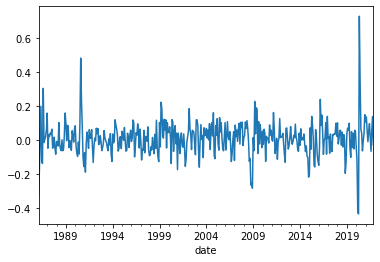

In [2]:
wti = pd.read_csv('data/WTI.csv', parse_dates=True, index_col='date', dayfirst=True).sort_index()['spot'].pct_change().dropna()
wti.plot()

In [3]:
av = wti.groupby(wti.index.year).std()
print(len(av))

36


In [4]:
wti_av = wti.index.map(lambda x: av.loc[x.year])
print(len(wti_av) == len(wti))

True


In [5]:
wti = wti/wti_av

<AxesSubplot:xlabel='date'>

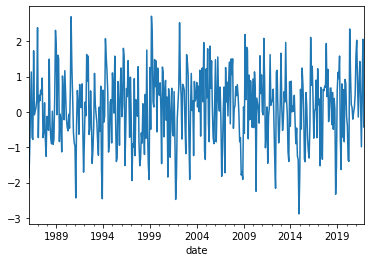

In [6]:
wti.plot()

<AxesSubplot:xlabel='date'>

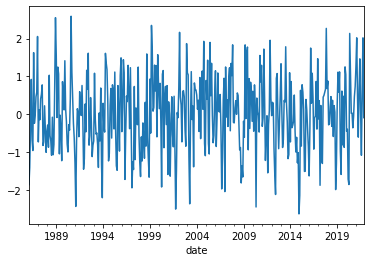

In [7]:
ma = wti.groupby(wti.index.month).mean()
wti_ma = wti.index.map(lambda x: ma.loc[x.month])
wti = wti - wti_ma
wti.plot()

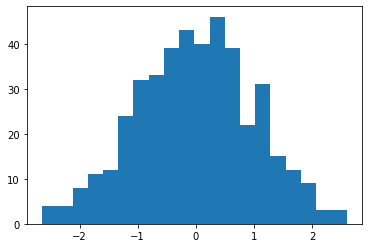

In [8]:
plt.hist(wti, bins=20)
plt.show()

<AxesSubplot:xlabel='date'>

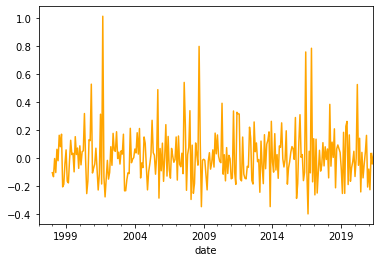

In [9]:
epu = pd.read_csv('data/EPUGlobal.csv', parse_dates=True, index_col='date', dayfirst=True).sort_index()
epu['MA2'] = epu.GEPU_current.rolling(12).mean()
epu_shock = epu.GEPU_current.pct_change() - epu.MA2.pct_change()
epu_shock.plot(color='orange')

<AxesSubplot:xlabel='date'>

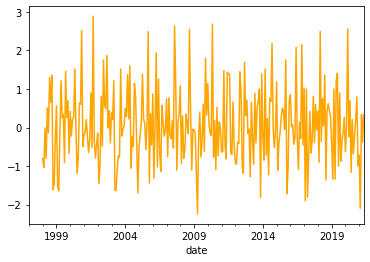

In [10]:
av1 = epu_shock.groupby(epu_shock.index.year).std()
epu_av = epu_shock.index.map(lambda x: av1.loc[x.year])
epu_shock = epu_shock/epu_av
epu_shock.plot(color='orange')

<AxesSubplot:xlabel='date'>

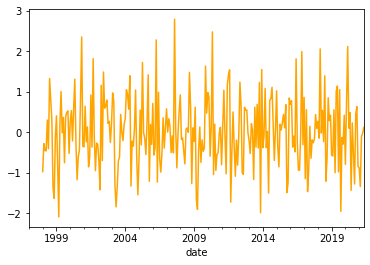

In [11]:
ma1 = epu_shock.groupby(epu_shock.index.month).mean()
epu_ma = epu_shock.index.map(lambda x: ma1.loc[x.month])
epu_shock = epu_shock - epu_ma
epu_shock.plot(color='orange')

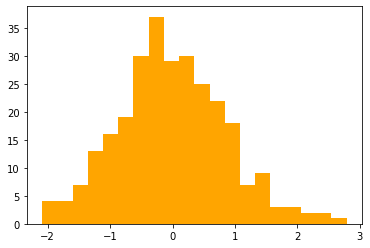

In [12]:
plt.hist(epu_shock, bins=20, color='orange')
plt.show()

In [13]:
df = pd.DataFrame(wti.rename('wti')).join(epu_shock.rename('epu_shock')).dropna()
df.head()

,wti,epu_shock
date,,
1998-01-01,-1.653551,-0.972885
1998-02-01,-0.602923,-0.279700
1998-03-01,-1.241328,-0.453002
1998-04-01,-0.233244,-0.460158
1998-05-01,-0.642636,0.298668


In [14]:
model1 = dl('wti', 'epu_shock', df)
model1.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    wti   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     2.091
Date:                Fri, 31 Dec 2021   Prob (F-statistic):             0.0151
Time:                        18:30:42   Log-Likelihood:                -367.18
No. Observations:                 269   AIC:                             762.4
Df Residuals:                     255   BIC:                             812.7
Df Model:                          13                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0779      0.058      1.344      0.180      -0.036       0.192
epu_shock-lag0     -0.2187      0.078     -2.797      0.006      -0.373      -0.065
epu_shock-lag1     -0.2231      0.080     -2.803      0.005      -0.380      -0.066
epu_shock-lag2     -0.1502      0.073     -2.046      0.042      -0.295      -0.006
epu_shock-lag3     -0.0315      0.071     -0.441      0.659      -0.172       0.109
epu_shock-lag4     -0.1075      0.072     -1.484      0.139      -0.250       0.035
epu_shock-lag5     -0.1309      0.070     -1.860      0.064      -0.270       0.008
epu_shock-lag6     -0.0853      0.069     -1.228      0.220      -0.222       0.051
epu_shock-lag7     -0.1425      0.067     -2.114      0.035      -0.275      -0.010
epu_shock-lag8     -0.0067      0.073     -0.092      0.927      -0.151       0.138
epu_shock-lag9     -0.1354      0.073     -1.868      0.063      -0.278       0.007
epu_shock-lag10    -0.1175      0.069     -1.704      0.090      -0.253       0.018
epu_shock-lag11    -0.1013      0.073     -1.391      0.166      -0.245       0.042
epu_shock-lag12    -0.1547      0.079     -1.966      0.050      -0.310       0.000
==============================================================================
Omnibus:                        1.387   Durbin-Watson:                   1.730
Prob(Omnibus):                  0.500   Jarque-Bera (JB):                1.294
Skew:                          -0.040   Prob(JB):                        0.523
Kurtosis:                       2.670   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

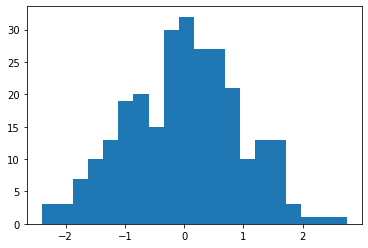

In [15]:
plt.hist(model1.resid, bins=20)
plt.show()

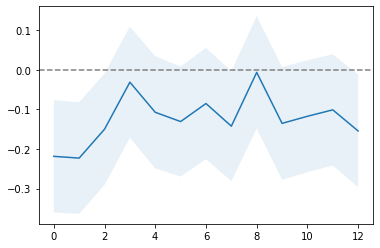

In [16]:
plt.plot(model1.params[1:].reset_index(drop=True))
plt.fill_between([*range(13)], model1.conf_int()[0][1:], model1.conf_int()[1][1:], alpha=.1)
plt.axhline(y=0, color='grey', linestyle='--')

### VAR

In [17]:
from scipy.stats import pearsonr
from statsmodels.tsa.api import VAR

In [18]:
for l in range(1, 15):
    res = pearsonr(df['wti'].iloc[l:], df['epu_shock'].iloc[:-l])
    print(f'Lag {l}: {res}')

Lag 1: (-0.10837700023161154, 0.07018446113483724)
Lag 2: (-0.044455774166400376, 0.4595489276494359)
Lag 3: (0.04468185315709687, 0.4580817034782196)
Lag 4: (-0.012749075637508309, 0.8327031390287694)
Lag 5: (-0.08926550748742475, 0.13908312951886426)
Lag 6: (-0.0255477779953681, 0.6731702380516754)
Lag 7: (-0.0726633981891107, 0.2305746296929187)
Lag 8: (0.09184545773048725, 0.13008312650415607)
Lag 9: (-0.031587753218359715, 0.6039777429876048)
Lag 10: (-0.02448548661821536, 0.6882147507816044)
Lag 11: (-0.03757048967949035, 0.5387535057639115)
Lag 12: (-0.06983319463230638, 0.25369940096547344)
Lag 13: (0.02540365009197057, 0.6788751280905526)
Lag 14: (0.011799139118344036, 0.8478192587151753)


In [19]:
model2 = VAR(df.dropna()).fit(maxlags=5)
model2.summary()

C:\Users\ztche\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 31, Dec, 2021
Time:                     18:30:42
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  0.0385850
Nobs:                     276.000    HQIC:                 -0.134194
Log likelihood:          -726.754    FPE:                   0.778868
AIC:                    -0.249998    Det(Omega_mle):        0.720308
--------------------------------------------------------------------
Results for equation wti
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.041268         0.060270            0.685           0.494
L1.wti               0.147255         0.061586            2.391           0.017
L1.epu_shock        -0.111694         0.071802           -1.556   

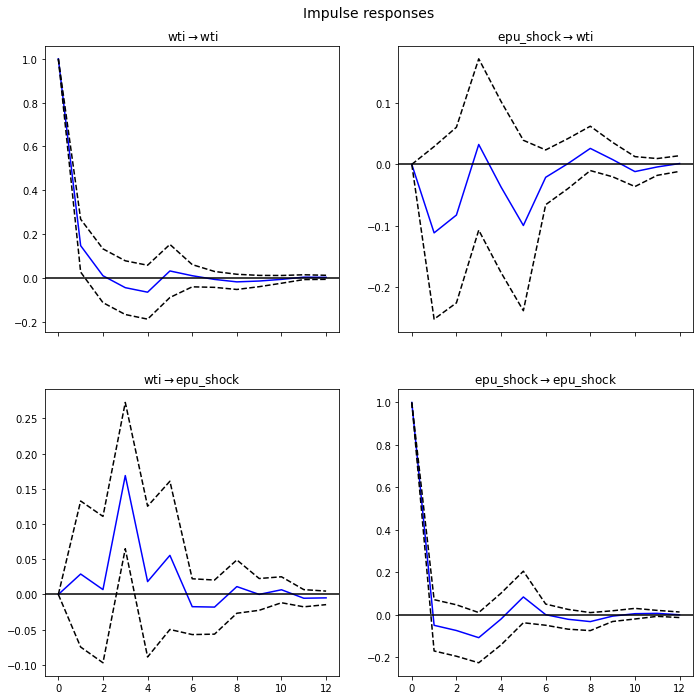

In [20]:
s = model2.irf(12).plot(orth=False)

### ARDL

In [21]:
from statsmodels.tsa.stattools import grangercausalitytests

In [22]:
gct = grangercausalitytests(pd.DataFrame(epu_shock.rename('epu_shock')).join(wti.rename('wti')).dropna(), 1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7579  , p=0.3847  , df_denom=277, df_num=1
ssr based chi2 test:   chi2=0.7661  , p=0.3814  , df=1
likelihood ratio test: chi2=0.7651  , p=0.3817  , df=1
parameter F test:         F=0.7579  , p=0.3847  , df_denom=277, df_num=1


In [23]:
from statsmodels.graphics.tsaplots import plot_pacf

C:\Users\ztche\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


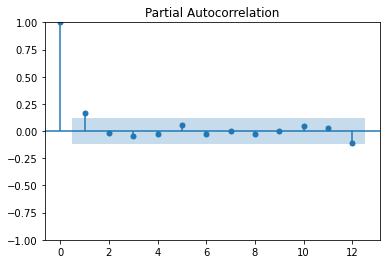

In [24]:
s = plot_pacf(df['wti'], lags=12, alpha=.05)

In [25]:
model3 = ardl('wti', 'epu_shock', df, lags=[1,12])

In [26]:
model3.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    wti   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     2.059
Date:                Fri, 31 Dec 2021   Prob (F-statistic):             0.0145
Time:                        18:30:43   Log-Likelihood:                -364.69
No. Observations:                 269   AIC:                             759.4
Df Residuals:                     254   BIC:                             813.3
Df Model:                          14                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0696      0.059      1.188      0.236      -0.046       0.185
wti-lag1            0.1332      0.062      2.151      0.032       0.011       0.255
epu_shock-lag0     -0.2180      0.079     -2.772      0.006      -0.373      -0.063
epu_shock-lag1     -0.1975      0.080     -2.469      0.014      -0.355      -0.040
epu_shock-lag2     -0.1244      0.072     -1.731      0.085      -0.266       0.017
epu_shock-lag3     -0.0166      0.070     -0.237      0.813      -0.154       0.121
epu_shock-lag4     -0.1051      0.072     -1.451      0.148      -0.248       0.038
epu_shock-lag5     -0.1205      0.070     -1.730      0.085      -0.258       0.017
epu_shock-lag6     -0.0684      0.069     -0.987      0.325      -0.205       0.068
epu_shock-lag7     -0.1350      0.067     -2.012      0.045      -0.267      -0.003
epu_shock-lag8      0.0127      0.075      0.169      0.866      -0.135       0.161
epu_shock-lag9     -0.1383      0.072     -1.914      0.057      -0.281       0.004
epu_shock-lag10    -0.1048      0.069     -1.521      0.130      -0.240       0.031
epu_shock-lag11    -0.0892      0.072     -1.245      0.214      -0.230       0.052
epu_shock-lag12    -0.1449      0.077     -1.873      0.062      -0.297       0.007
==============================================================================
Omnibus:                        1.370   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.504   Jarque-Bera (JB):                1.295
Skew:                           0.050   Prob(JB):                        0.523
Kurtosis:                       2.675   Cond. No.                         2.08
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

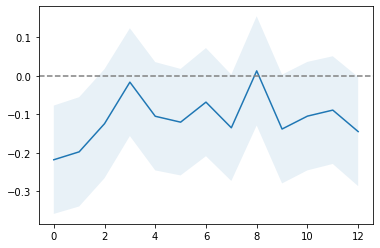

In [27]:
plt.plot(model3.params[2:].reset_index(drop=True))
plt.fill_between([*range(13)], model3.conf_int()[0][2:], model3.conf_int()[1][2:], alpha=.1)
plt.axhline(y=0, color='grey', linestyle='--')

Given that VAR model is dependent on construction, it may be better to use the single equation models. ARDL has a higher adjusted R^2 than DL, which implies it is better at explaining variations in the data.